In [3]:
## testing multidark
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kde
import h5py
import astropy.io.fits as fits
import csv
import pandas as pd
import h5py
import tables
import pickle5 as pickle
import os
from astropy.table import Table
from astropy.coordinates import SkyCoord
from tqdm import tqdm
from astropy.io import ascii
import os
from glob import glob

In [4]:
from pygadgetreader import *

In [5]:
import warnings
warnings.filterwarnings("ignore")

In [6]:
from timeit import default_timer as timer

In [7]:
import sys
sys.path.append('/global/homes/z/zzhang13/BaryonPasting/CorrelatedStructures/')

In [8]:
ptcl_dir = '/global/cscratch1/sd/zzhang13/MultiDark/MDPL2_particles/z0p00/'
clusters_dir = '/global/cscratch1/sd/zzhang13/MultiDark/MDPL2_ROCKSTAR_Halos/z0p00/'

## Importing the cluster catalog. 

In [9]:
import pandas as pd
cluster_df = pd.read_csv(clusters_dir + 'clusters_SAGE_mvir_lgt_5e13.csv')

In [10]:
mvir_low = 1e14; mvir_high = 5e14
sample_num = 10

mask = (cluster_df.mvir >= mvir_low) & (cluster_df.mvir < mvir_high)
cur_df = cluster_df[mask]
cur_df = cur_df.head(sample_num) ##Get the first 100 clusters

## Configuring varaibles for reading DeltaSigma

In [30]:
##Global variables
box_length = 1000
ptcl_mass = 1.505e9 ##Msun/h
ptcl_samp = 1000 #Sample every 1000th particle
dz = 200 ## Projection depth Mpc/h
r_bins_log_norm = np.linspace(-1,1,22)
r_bins_lin_norm = 10**r_bins_log_norm
r_cent_log_norm= (r_bins_log_norm[1:] + r_bins_log_norm[:-1])/2
r_cent_lin_norm = 10**r_cent_log_norm


## Reading the downsampled particle file

In [16]:
with open(ptcl_dir + 'MDPL2_dm_ptcl_1000th.pkl', "rb") as handle:
    ptcl = pickle.load(handle)

## Computing Sigma and DeltaSigma

In [31]:
output = {}

x = np.array(cur_df.x); y = np.array(cur_df.y); z = np.array(cur_df.z)
mvir = np.array(cur_df.mvir); rvir = np.array(cur_df.rvir)/1000
Ngal = np.array(cur_df.Ngal)
cluster_id = np.array(cur_df.id)
        
#Derived quantities
r_range = r_bins_lin_norm*rvir[:,np.newaxis]
sigma = np.zeros((sample_num, len(r_cent_lin_norm)))
deltasigma = np.zeros((sample_num, len(r_cent_lin_norm)))

## Compute Delta Sigma
start = timer()

for i in range(sample_num):
        r_range_cl = r_range[i]
        sigma_cl = np.zeros(len(r_cent_lin_norm))
        deltasigma_cl = np.zeros(len(r_cent_lin_norm))
        
        ##Periodic boundary condition for annulus. Halos are conditions at [0,1000] Mpc boundaries.       
        dx_sqr = np.asarray([(ptcl[:,0]-x[i])**2, (ptcl[:,0]-x[i]+box_length)**2, (ptcl[:,0]-x[i]-box_length)**2]).min(0)
        dy_sqr = np.asarray([(ptcl[:,1]-y[i])**2, (ptcl[:,1]-y[i]+box_length)**2, (ptcl[:,1]-y[i]-box_length)**2]).min(0)
        dz_min = np.asarray([np.abs(ptcl[:,2]-z[i]), np.abs(ptcl[:,2]-z[i]+box_length), np.abs(ptcl[:,2]-z[i]-box_length)]).min(0)

        for j in range(len(r_cent_lin_norm)):
            #radius for annulus
            dr = r_range_cl[j+1] - r_range_cl[j]
            r_cur = r_range_cl[j]

            #Masking
            mask_DS = dx_sqr + dy_sqr < (r_cur+dr)**2 
            mask_DS &= dz_min < dz
            mask_Sigma = mask_DS & (dx_sqr + dy_sqr >= (r_cur)**2)
        
            #Building an annulus
            annulus_df = ptcl[mask_Sigma]

            #Find 2D density within the annulus
            area_annulus = np.pi * ((r_cur+dr)**2 - (r_cur)**2.)
            m_annulus = len(annulus_df)*ptcl_mass*ptcl_samp
            sigma_cl[j] = m_annulus/area_annulus
            
            ##Finding DeltaSigma
            circle_df = ptcl[mask_DS]
            area_circle = np.pi*r_cur**2.
            m_circle = len(circle_df)*ptcl_mass*ptcl_samp
            sigma_avg = m_circle/area_circle
            deltasigma_cl[j] = sigma_avg - sigma_cl[j]
                
        sigma[i] += sigma_cl
        deltasigma[i] += deltasigma_cl
        print("Completed reading cluster: ", cluster_id[i])
    
end = timer()
print("Time elapsed  = ", end-start)


output['cluster_id'] = cluster_id
output['sigma'] = sigma
output['deltasigma'] = deltasigma

Completed reading cluster:  12592929268
Completed reading cluster:  12592317707
Completed reading cluster:  12592352396
Completed reading cluster:  12592318197
Completed reading cluster:  12592352641
Completed reading cluster:  12592318510
Completed reading cluster:  12583641791
Completed reading cluster:  12592890829
Completed reading cluster:  12592319043
Completed reading cluster:  12583641020
Time elapsed  =  234.7181756598875


In [32]:
mean_sigma = np.mean(output['sigma']*1000, axis=0)
mean_DS = np.mean(output['deltasigma']*1000, axis=0)

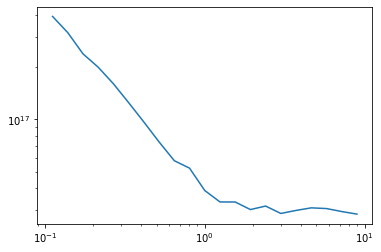

In [34]:
plt.plot(r_cent_lin_norm, mean_sigma)
plt.yscale('log')
plt.xscale('log')

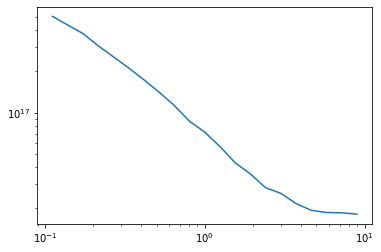

In [35]:
plt.plot(r_cent_lin_norm, mean_DS)
plt.yscale('log')
plt.xscale('log')

## Read the parallel files

In [36]:
with open('deltasigma_multiprocess_1000th_ptcl_test.pkl', "rb") as handle:
    output_mpi = pickle.load(handle)

In [40]:
r_bins_log_norm = np.linspace(-1,1,21)
r_bins_lin_norm = 10**r_bins_log_norm
r_cent_log_norm= (r_bins_log_norm[1:] + r_bins_log_norm[:-1])/2
r_cent_lin_norm = 10**r_cent_log_norm

In [41]:
mean_sigma_mpi = np.mean(output_mpi['sigma'], axis=0)
mean_DS_mpi = np.mean(output_mpi['delta_sigma'], axis=0)

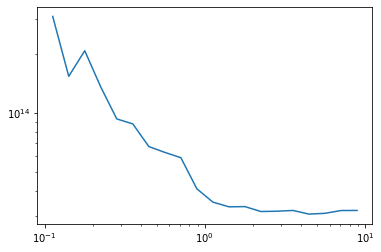

In [42]:
plt.plot(r_cent_lin_norm, mean_sigma_mpi)
plt.yscale('log')
plt.xscale('log')

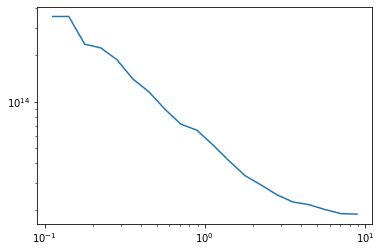

In [43]:
plt.plot(r_cent_lin_norm, mean_DS_mpi)
plt.yscale('log')
plt.xscale('log')